<a href="https://colab.research.google.com/github/H-T0rres/H-T0rres.github.io/blob/main/AbstractArtCTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
project_name = 'abstract art'

In [ ]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

## Downloading and Exploring the Data

We can use the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/splcher/animefacedataset) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle.  Follow these steps to find your API credentials:

1. Sign in to  [https://kaggle.com/](https://kaggle.com),  then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file `kaggle.json` with the following contents:

```
{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
```

3. When you run `opendatsets.download`, you will be asked to enter your username & Kaggle API, which you can get from the file downloaded in step 2.

Note that you need to download the `kaggle.json` file only once. On Google Colab, you can also upload the `kaggle.json` file using the files tab, and the credentials will be read automatically.


In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/bryanb/abstract-art-gallery?resource=download'
od.download(dataset_url)

100%|██████████| 693M/693M [00:35<00:00, 20.5MB/s]


The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [4]:
import os

DATA_DIR = './abstract-art-gallery'
print(os.listdir(DATA_DIR))

['Abstract_gallery', 'Abstract_gallery_2']


In [5]:
print(os.listdir(DATA_DIR+'/Abstract_gallery/Abstract_gallery')[:10])

['Abstract_image_922.jpg', 'Abstract_image_1196.jpg', 'Abstract_image_1820.jpg', 'Abstract_image_1130.jpg', 'Abstract_image_248.jpg', 'Abstract_image_443.jpg', 'Abstract_image_321.jpg', 'Abstract_image_633.jpg', 'Abstract_image_1051.jpg', 'Abstract_image_395.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

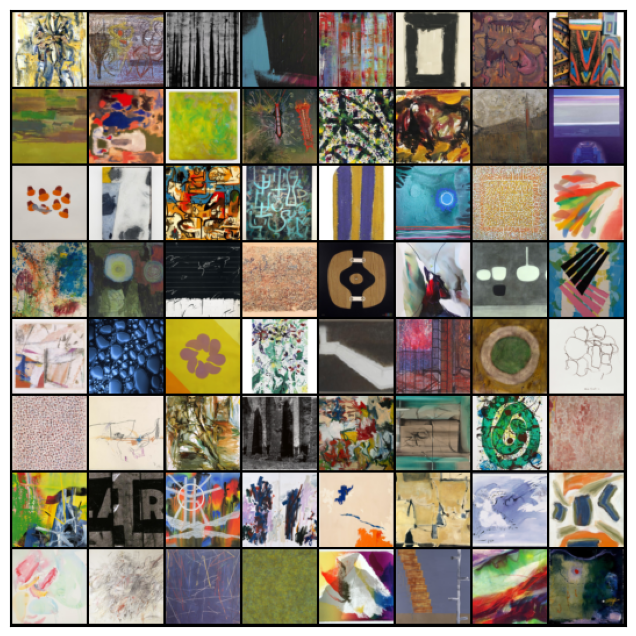

In [12]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [14]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [16]:
import torch.nn as nn

In [17]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [18]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [20]:
latent_size = 100
# you could change this and results would be a little different
#the number of latent could contain certain parts of the image like hair, mouth, and expression
#increase the size to increase the detail

In [21]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


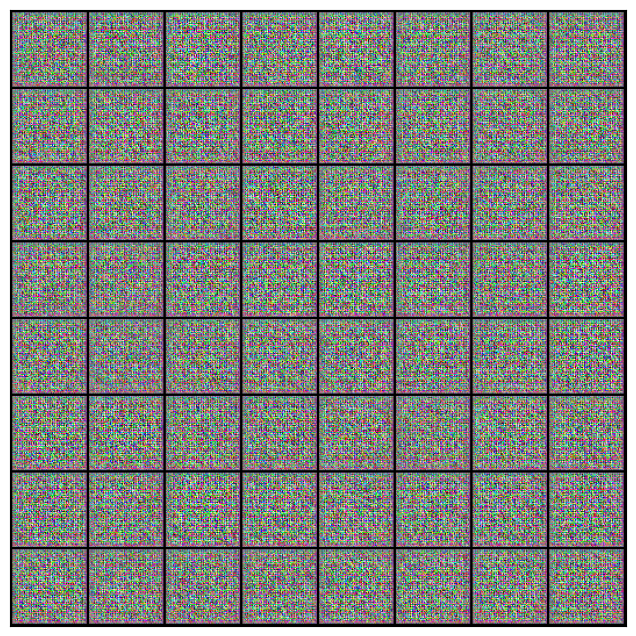

In [22]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet.

Let's move the generator to the chosen device.

In [23]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [24]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

- We first pass a batch of real images, and compute the loss, setting the target labels to 1.

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [25]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [26]:
from torchvision.utils import save_image

In [27]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [28]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [29]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


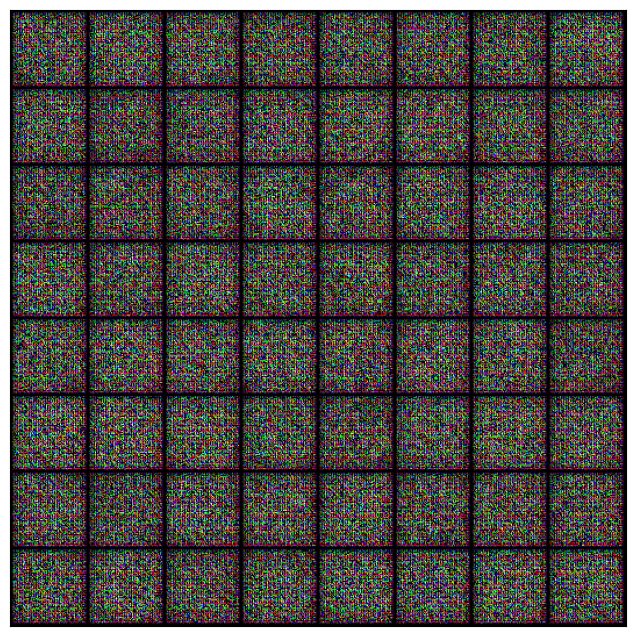

In [30]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [31]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [32]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [33]:
lr = 0.0002
epochs = 50

In [42]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

NameError: ignored

In [34]:
history = fit(epochs, lr)

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 7.3422, loss_d: 0.2893, real_score: 0.8214, fake_score: 0.0642
Saving generated-images-0001.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 11.3009, loss_d: 0.8018, real_score: 0.8903, fake_score: 0.4865
Saving generated-images-0002.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 6.6585, loss_d: 0.3513, real_score: 0.8933, fake_score: 0.1907
Saving generated-images-0003.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 4.4912, loss_d: 0.0975, real_score: 0.9676, fake_score: 0.0613
Saving generated-images-0004.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 3.9123, loss_d: 0.2522, real_score: 0.9203, fake_score: 0.1513
Saving generated-images-0005.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 4.5626, loss_d: 0.1584, real_score: 0.9488, fake_score: 0.0979
Saving generated-images-0006.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 5.2655, loss_d: 0.3548, real_score: 0.9477, fake_score: 0.2495
Saving generated-images-0007.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 5.6722, loss_d: 3.6291, real_score: 0.9924, fake_score: 0.9473
Saving generated-images-0008.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 1.6299, loss_d: 0.6890, real_score: 0.6498, fake_score: 0.1849
Saving generated-images-0009.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 2.0389, loss_d: 0.9901, real_score: 0.4699, fake_score: 0.0196
Saving generated-images-0010.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 5.9865, loss_d: 0.8049, real_score: 0.8740, fake_score: 0.4050
Saving generated-images-0011.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.2418, loss_d: 0.2543, real_score: 0.8639, fake_score: 0.0854
Saving generated-images-0012.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 2.8766, loss_d: 0.5877, real_score: 0.7059, fake_score: 0.1855
Saving generated-images-0013.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.3060, loss_d: 0.4030, real_score: 0.8133, fake_score: 0.1492
Saving generated-images-0014.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.2931, loss_d: 0.3980, real_score: 0.8432, fake_score: 0.1821
Saving generated-images-0015.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.7743, loss_d: 0.5455, real_score: 0.9010, fake_score: 0.3145
Saving generated-images-0016.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.8495, loss_d: 1.5576, real_score: 0.2750, fake_score: 0.0026
Saving generated-images-0017.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 3.1801, loss_d: 0.3999, real_score: 0.8652, fake_score: 0.2135
Saving generated-images-0018.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 4.3236, loss_d: 1.6560, real_score: 0.2889, fake_score: 0.0043
Saving generated-images-0019.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 2.6304, loss_d: 0.6430, real_score: 0.6327, fake_score: 0.0907
Saving generated-images-0020.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 4.8020, loss_d: 0.8219, real_score: 0.7703, fake_score: 0.3975
Saving generated-images-0021.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 2.7677, loss_d: 0.8962, real_score: 0.4828, fake_score: 0.0208
Saving generated-images-0022.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 3.8341, loss_d: 0.3358, real_score: 0.9306, fake_score: 0.2226
Saving generated-images-0023.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.2931, loss_d: 0.5785, real_score: 0.7897, fake_score: 0.2542
Saving generated-images-0024.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.4106, loss_d: 0.6713, real_score: 0.9204, fake_score: 0.4076
Saving generated-images-0025.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 3.0523, loss_d: 0.6123, real_score: 0.5992, fake_score: 0.0332
Saving generated-images-0026.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.1067, loss_d: 0.5949, real_score: 0.8744, fake_score: 0.3285
Saving generated-images-0027.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 4.8811, loss_d: 0.7843, real_score: 0.8296, fake_score: 0.4061
Saving generated-images-0028.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.9666, loss_d: 1.0208, real_score: 0.9759, fake_score: 0.5607
Saving generated-images-0029.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 3.8717, loss_d: 0.9305, real_score: 0.7804, fake_score: 0.4502
Saving generated-images-0030.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 3.6870, loss_d: 0.6670, real_score: 0.7892, fake_score: 0.3086
Saving generated-images-0031.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.4433, loss_d: 0.6268, real_score: 0.6599, fake_score: 0.1432
Saving generated-images-0032.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.2496, loss_d: 0.6601, real_score: 0.7162, fake_score: 0.2348
Saving generated-images-0033.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 5.2718, loss_d: 1.1586, real_score: 0.9039, fake_score: 0.5939
Saving generated-images-0034.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 5.0122, loss_d: 0.5211, real_score: 0.9144, fake_score: 0.3314
Saving generated-images-0035.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 2.8645, loss_d: 0.3417, real_score: 0.9166, fake_score: 0.2056
Saving generated-images-0036.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 3.8618, loss_d: 0.5408, real_score: 0.9295, fake_score: 0.3357
Saving generated-images-0037.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.0415, loss_d: 0.6486, real_score: 0.7223, fake_score: 0.2031
Saving generated-images-0038.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 1.4674, loss_d: 1.4551, real_score: 0.2883, fake_score: 0.0058
Saving generated-images-0039.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 2.1259, loss_d: 1.2462, real_score: 0.3591, fake_score: 0.0255
Saving generated-images-0040.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 2.9894, loss_d: 0.6715, real_score: 0.5956, fake_score: 0.0391
Saving generated-images-0041.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 2.8830, loss_d: 0.3768, real_score: 0.7556, fake_score: 0.0581
Saving generated-images-0042.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.0415, loss_d: 0.8831, real_score: 0.4752, fake_score: 0.0190
Saving generated-images-0043.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 4.5231, loss_d: 0.6699, real_score: 0.8636, fake_score: 0.3550
Saving generated-images-0044.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 3.8424, loss_d: 0.6100, real_score: 0.6371, fake_score: 0.0472
Saving generated-images-0045.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.8654, loss_d: 0.6361, real_score: 0.8890, fake_score: 0.3727
Saving generated-images-0046.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 3.8729, loss_d: 0.5754, real_score: 0.8325, fake_score: 0.2894
Saving generated-images-0047.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.1420, loss_d: 0.4778, real_score: 0.8678, fake_score: 0.2498
Saving generated-images-0048.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.5314, loss_d: 0.7498, real_score: 0.9085, fake_score: 0.4401
Saving generated-images-0049.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 2.9552, loss_d: 0.5483, real_score: 0.8827, fake_score: 0.2994
Saving generated-images-0050.png


In [38]:
losses_g, losses_d, real_scores, fake_scores = history

In [41]:
jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d=losses_d[-1],
                   real_score=real_scores[-1],
                   fake_score=fake_scores[-1])

NameError: ignored

Now that we have trained the models, we can save checkpoints.

In [35]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [36]:
from IPython.display import Image

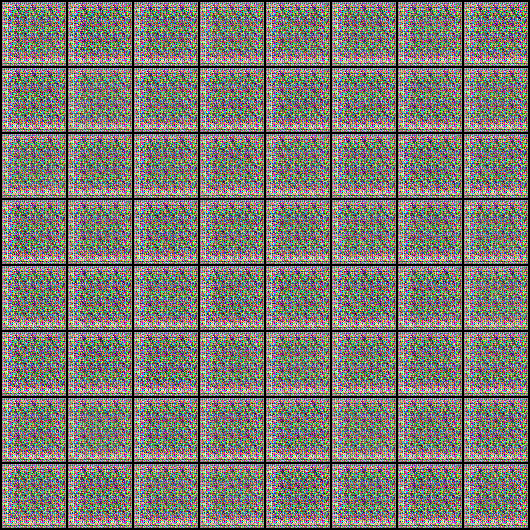

In [40]:
Image('./generated/generated-images-0001.png')

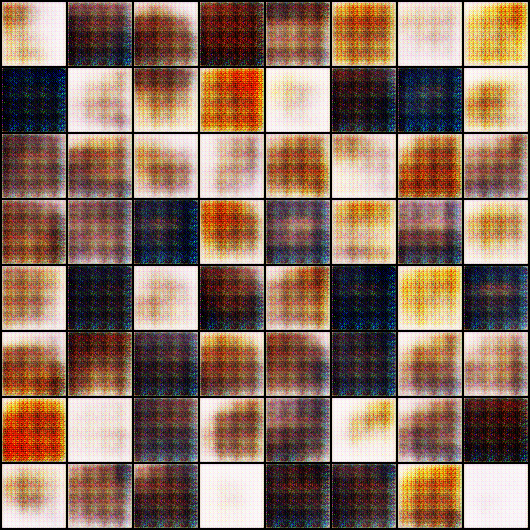

In [39]:
Image('./generated/generated-images-0010.png')

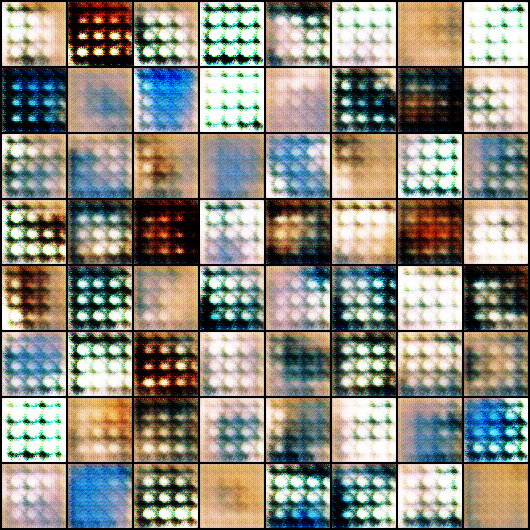

In [41]:
Image('./generated/generated-images-0020.png')

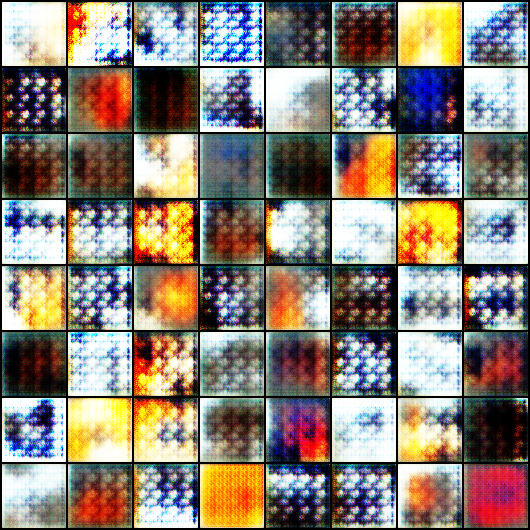

In [42]:
Image('./generated/generated-images-0030.png')

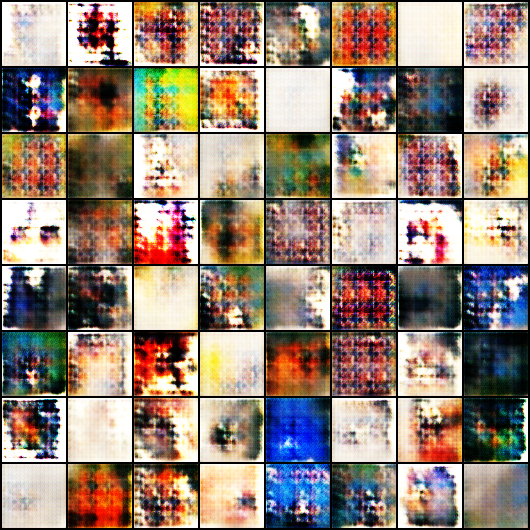

In [43]:
Image('./generated/generated-images-0050.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [44]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



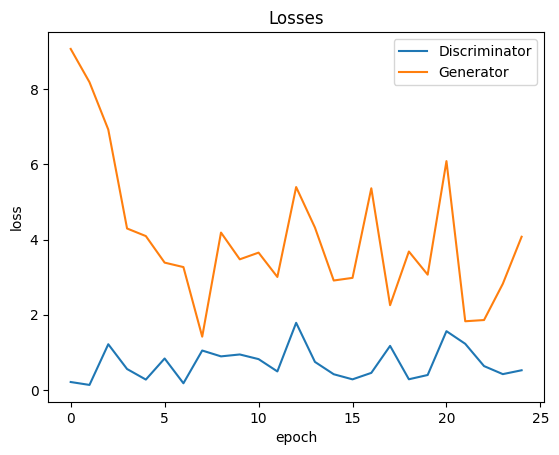

In [52]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

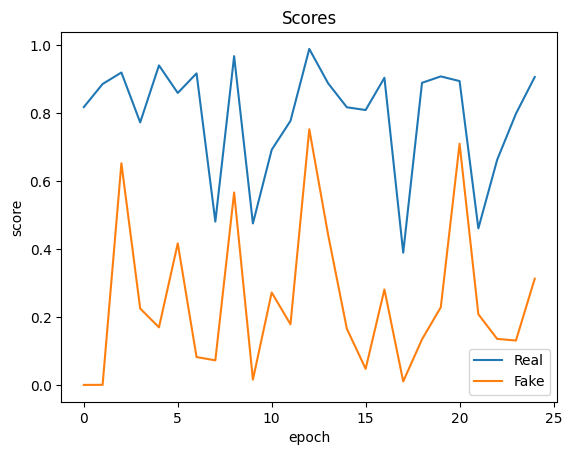

In [53]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Save and Commit

We can upload the full snapshot of this experiment to Jovian:
- Jupyter notebook
- Hyperparameters & metrics
- Models weights
- Training video

In [59]:
import jovian

In [60]:
jovian.commit(project=project_name,
              outputs=['G.pth', 'D.pth', 'gans_training.avi'],
              environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
